In [1]:
import pandas as pd
import numpy as np
import random

# Reproducibility
np.random.seed(42)
random.seed(42)

def generate_corrosion_dataset(
    num_samples=5000,
    output_file="corrosion_pipeline_data.csv"
):

    materials = {
        "Carbon Steel": 0.45,
        "SS304": 0.18,
        "SS316": 0.14,
        "Alloy Steel": 0.35,
        "Inconel": 0.06
    }

    data = []

    for _ in range(num_samples):
        material = random.choice(list(materials.keys()))
        base_rate = materials[material]

        temperature = np.random.uniform(140, 280)        # °C
        pressure = np.random.uniform(25, 55)             # bar
        ph = np.random.uniform(4.2, 6.8)
        sulfur = np.random.uniform(100, 700)             # ppm
        velocity = np.random.uniform(1.5, 4.5)           # m/s
        service_years = np.random.randint(1, 15)

        # Corrosion logic
        temp_factor = (temperature - 140) / 140
        ph_factor = (6.8 - ph)
        sulfur_factor = sulfur / 700
        velocity_factor = velocity / 4.5
        age_factor = service_years / 15

        corrosion_rate = (
            base_rate
            + 0.25 * temp_factor
            + 0.15 * ph_factor
            + 0.30 * sulfur_factor
            + 0.20 * velocity_factor
            + 0.10 * age_factor
        )

        corrosion_rate = round(max(corrosion_rate, 0.02), 2)

        data.append([
            material,
            round(temperature, 1),
            round(pressure, 1),
            round(ph, 2),
            int(sulfur),
            round(velocity, 2),
            service_years,
            corrosion_rate
        ])

    df = pd.DataFrame(
        data,
        columns=[
            "material",
            "temperature_c",
            "pressure_bar",
            "ph",
            "sulfur_ppm",
            "flow_velocity_ms",
            "service_years",
            "corrosion_rate_mmpy"
        ]
    )

    df.to_csv(output_file, index=False)
    print(f"Dataset saved as {output_file}")
    return df


# Generate dataset
df = generate_corrosion_dataset(num_samples=5000)
df.head()

Dataset saved as corrosion_pipeline_data.csv


,material,temperature_c,pressure_bar,ph,sulfur_ppm,flow_velocity_ms,service_years,corrosion_rate_mmpy
0,Carbon Steel,192.4,53.5,6.10,459,1.97,3,0.95
1,Carbon Steel,154.0,38.8,5.07,185,3.45,5,1.00
2,SS316,275.8,50.0,4.75,209,2.05,12,0.95
3,SS304,225.6,25.2,4.26,414,2.70,12,1.09
4,SS304,276.3,32.0,4.44,471,2.65,4,1.12


In [2]:
df.shape

(5000, 8)

In [3]:
df.isnull().sum()

,0
material,0
temperature_c,0
pressure_bar,0
ph,0
sulfur_ppm,0
flow_velocity_ms,0
service_years,0
corrosion_rate_mmpy,0


**Start**

In [4]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


2️⃣ Quick Data Overview
pythonCopy code

In [6]:
df.head()

,material,temperature_c,pressure_bar,ph,sulfur_ppm,flow_velocity_ms,service_years,corrosion_rate_mmpy
0,Carbon Steel,192.4,53.5,6.10,459,1.97,3,0.95
1,Carbon Steel,154.0,38.8,5.07,185,3.45,5,1.00
2,SS316,275.8,50.0,4.75,209,2.05,12,0.95
3,SS304,225.6,25.2,4.26,414,2.70,12,1.09
4,SS304,276.3,32.0,4.44,471,2.65,4,1.12


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   material             5000 non-null   object 
 1   temperature_c        5000 non-null   float64
 2   pressure_bar         5000 non-null   float64
 3   ph                   5000 non-null   float64
 4   sulfur_ppm           5000 non-null   int64  
 5   flow_velocity_ms     5000 non-null   float64
 6   service_years        5000 non-null   int64  
 7   corrosion_rate_mmpy  5000 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 312.6+ KB


In [9]:
df.describe()

,temperature_c,pressure_bar,ph,sulfur_ppm,flow_velocity_ms,service_years,corrosion_rate_mmpy
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,210.728180,40.129080,5.495838,397.644400,3.001812,7.459200,0.911062
std,40.368491,8.645863,0.751213,171.543957,0.865402,4.070731,0.211241
min,140.000000,25.000000,4.200000,100.000000,1.500000,1.000000,0.300000
25%,175.700000,32.675000,4.850000,249.750000,2.250000,4.000000,0.760000
50%,211.100000,40.100000,5.510000,399.000000,3.025000,7.000000,0.900000
75%,245.300000,47.700000,6.140000,547.000000,3.740000,11.000000,1.060000
max,280.000000,55.000000,6.800000,699.000000,4.500000,14.000000,1.570000


3️⃣ Exploratory Data Analysis (EDA)


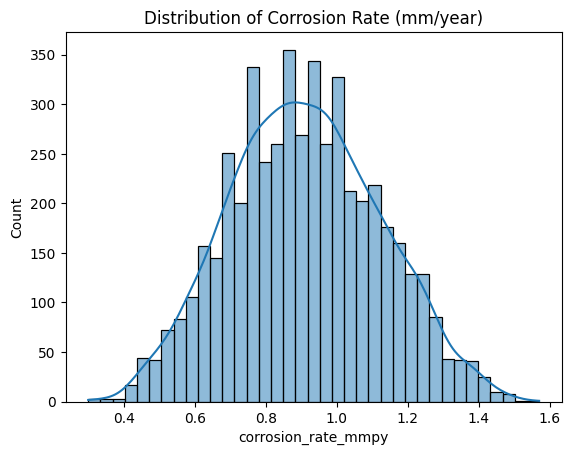

In [10]:
plt.figure()
sns.histplot(df['corrosion_rate_mmpy'], kde=True)
plt.title("Distribution of Corrosion Rate (mm/year)")
plt.show()


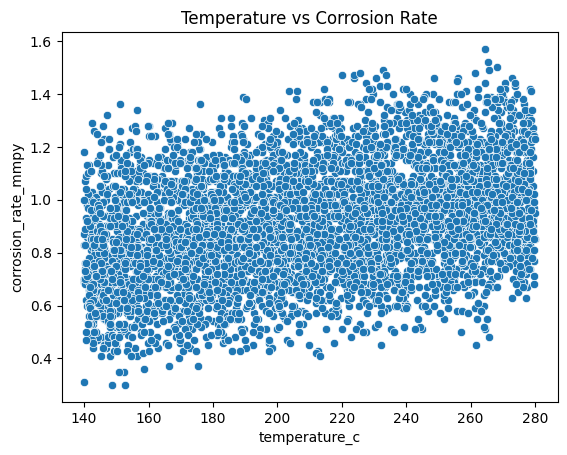

In [11]:
plt.figure()
sns.scatterplot(x='temperature_c', y='corrosion_rate_mmpy', data=df)
plt.title("Temperature vs Corrosion Rate")
plt.show()


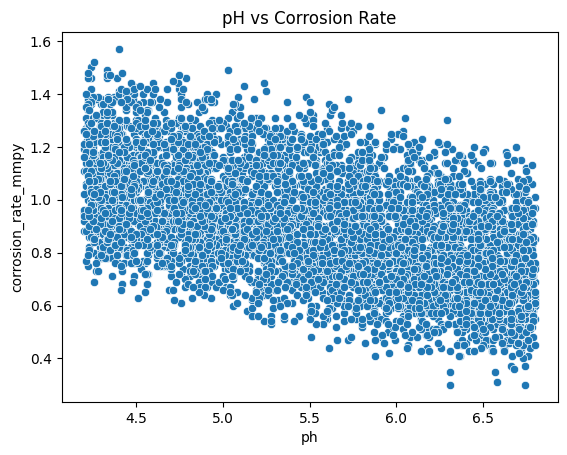

In [12]:
plt.figure()
sns.scatterplot(x='ph', y='corrosion_rate_mmpy', data=df)
plt.title("pH vs Corrosion Rate")
plt.show()


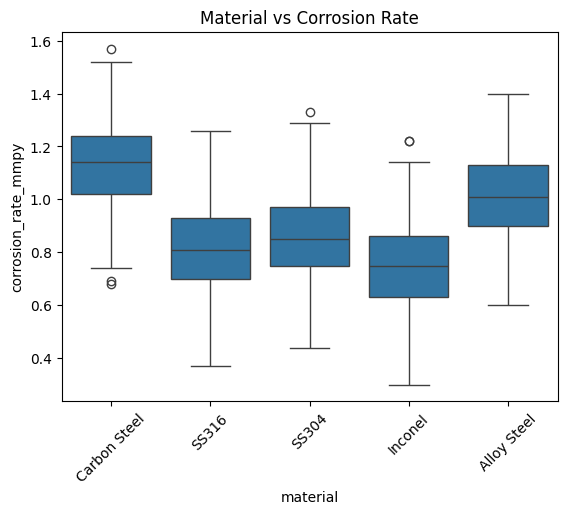

In [13]:
plt.figure()
sns.boxplot(x='material', y='corrosion_rate_mmpy', data=df)
plt.xticks(rotation=45)
plt.title("Material vs Corrosion Rate")
plt.show()


4️⃣ Feature & Target Separation
pythonCopy code

In [14]:
X = df.drop('corrosion_rate_mmpy', axis=1)
y = df['corrosion_rate_mmpy']

5️⃣ Identify Feature Types
pythonCopy code

In [15]:
categorical_features = ['material']
numerical_features = [
    'temperature_c',
    'pressure_bar',
    'ph',
    'sulfur_ppm',
    'flow_velocity_ms',
    'service_years'
]


6️⃣ Preprocessing Pipeline
pythonCopy code

In [16]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


7️⃣ Train-Test Split
pythonCopy code

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


8️⃣ Baseline Model – Linear Regression
pythonCopy code

In [18]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

print("Linear Regression Performance")
print("R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression Performance
R2 Score: 0.9998053340875063
RMSE: 0.0029587686151941336
MAE: 0.0025545078502797708


9️⃣ Advanced Model – Random Forest Regressor
pythonCopy code

In [19]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        max_depth=10
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Performance")
print("R2 Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))



Random Forest Performance
R2 Score: 0.9662592339106095
RMSE: 0.03895323383538818
MAE: 0.03072824249055942


🔟 Feature Importance (VERY IMPORTANT FOR INTERVIEWS)
pythonCopy code

In [21]:
feature_names_num = numerical_features
feature_names_cat = list(
    rf_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

feature_names = feature_names_num + feature_names_cat

importances = rf_pipeline.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)

,feature,importance
2,ph,0.279207
7,material_Carbon Steel,0.268013
6,material_Alloy Steel,0.152439
3,sulfur_ppm,0.123774
0,temperature_c,0.112484
4,flow_velocity_ms,0.027120
8,material_Inconel,0.021912
5,service_years,0.008446
9,material_SS304,0.003425
1,pressure_bar,0.002931


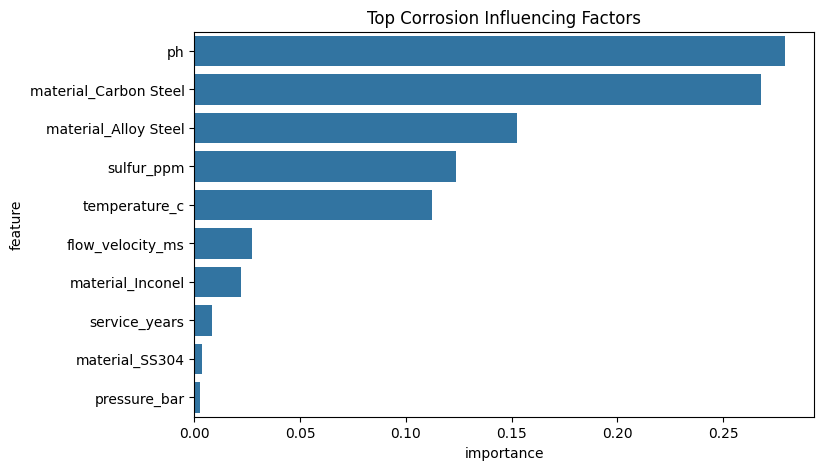

In [22]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(10)
)
plt.title("Top Corrosion Influencing Factors")
plt.show()


1️⃣1️⃣ Corrosion Risk Classification (Business Layer)
pythonCopy code

In [23]:
def corrosion_risk(rate):
    if rate < 0.2:
        return "Low"
    elif rate < 0.5:
        return "Medium"
    else:
        return "High"

df['corrosion_risk'] = df['corrosion_rate_mmpy'].apply(corrosion_risk)
df[['corrosion_rate_mmpy', 'corrosion_risk']].head()


,corrosion_rate_mmpy,corrosion_risk
0,0.95,High
1,1.00,High
2,0.95,High
3,1.09,High
4,1.12,High


1️⃣2️⃣ Model Prediction on New Data (Real-World Use)
pythonCopy code

In [24]:
new_data = pd.DataFrame({
    'material': ['Carbon Steel'],
    'temperature_c': [210],
    'pressure_bar': [40],
    'ph': [4.9],
    'sulfur_ppm': [620],
    'flow_velocity_ms': [3.2],
    'service_years': [9]
})

predicted_rate = rf_pipeline.predict(new_data)[0]
print("Predicted Corrosion Rate (mm/year):", predicted_rate)
print("Risk Level:", corrosion_risk(predicted_rate))


Predicted Corrosion Rate (mm/year): 1.2883941837181145
Risk Level: High


🔹 Save Model Using Pickle
pythonCopy code

In [25]:
import pickle

# Save trained model
with open("corrosion_model.pkl", "wb") as file:
    pickle.dump(rf_pipeline, file)

print("Model saved as corrosion_model.pkl")


Model saved as corrosion_model.pkl


In [28]:
df.head()

,material,temperature_c,pressure_bar,ph,sulfur_ppm,flow_velocity_ms,service_years,corrosion_rate_mmpy,corrosion_risk
0,Carbon Steel,192.4,53.5,6.10,459,1.97,3,0.95,High
1,Carbon Steel,154.0,38.8,5.07,185,3.45,5,1.00,High
2,SS316,275.8,50.0,4.75,209,2.05,12,0.95,High
3,SS304,225.6,25.2,4.26,414,2.70,12,1.09,High
4,SS304,276.3,32.0,4.44,471,2.65,4,1.12,High


In [30]:
df['corrosion_risk'].value_counts()

,count
corrosion_risk,
High,4905
Medium,95


In [32]:
new_data = pd.DataFrame({
    'material': ['Carbon Steel'],
    'temperature_c': [120],
    'pressure_bar': [27],
    'ph': [7],
    'sulfur_ppm': [150],
    'flow_velocity_ms': [2.7],
    'service_years': [3]
})

predicted_rate = rf_pipeline.predict(new_data)[0]
print("Predicted Corrosion Rate (mm/year):", predicted_rate)
print("Risk Level:", corrosion_risk(predicted_rate))


Predicted Corrosion Rate (mm/year): 0.7527491987179483
Risk Level: High
